# Quantum Feature Selection

## Data Acquisition and Preprocessing

In [1]:
from mnist import MNIST
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import cv2

plt.style.use(['science', 'grid'])
# default high dpi
plt.rcParams['figure.dpi'] = 200

PIC_LEN = 4
PIC_SIZE = PIC_LEN * PIC_LEN
NUM_SAMPLES = 10240

In [2]:
# download MNIST data
mndata = MNIST('./data')

In [3]:
images, labels = mndata.load_training()

# only take NUM_SAMPLES samples
images = images[:NUM_SAMPLES]
labels = labels[:NUM_SAMPLES]

In [4]:
images_shrinked = []
for image in images:
    # resize the image to 8 * 8 with opencv
    image = np.array(image).reshape((28, 28))
    # convert to cv2 image
    image = image.astype(np.uint8)
    # resize
    image = cv2.resize(image, (PIC_LEN, PIC_LEN))
    # back to numpy array
    image = np.array(image).reshape((PIC_SIZE,))
    images_shrinked.append(image)

In [5]:
# limit number of images and labels to 4096
images_shrinked = images_shrinked
labels = labels

In [6]:
# convert to dataframe with labels
df = pd.DataFrame(images_shrinked)
df['label'] = labels

In [7]:
# except labels, convert all pixels into 4 bins
for i in range(PIC_SIZE):
    df[i] = pd.cut(df[i], 4, labels=[0, 1, 2, 3])

In [8]:
df.to_csv('./mnist.csv', index=False)

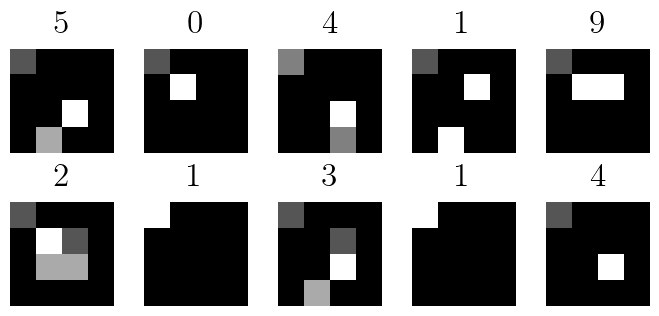

In [16]:
# display the first 10 images in df
fig = plt.figure()
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(df.iloc[i, :-1].values.reshape((PIC_LEN, PIC_LEN)), cmap='gray')
    ax.set_title(df.iloc[i, -1])
    # tight layout
    plt.tight_layout()
    ax.axis('off')
# tight layout
plt.tight_layout()
# title
plt.suptitle('MNIST Dataset Reduced')
# plt.savefig('./mnist.png', dpi=300)

## Formulating QUBO from the Feature Selection Problem

In [10]:
from sklearn.metrics import mutual_info_score
from tqdm import tqdm

In [11]:
# calculate importance term
features = df.iloc[:, :-1].values.astype(int)
labels = df.iloc[:, -1].values.astype(int)

importance = []
for i in tqdm(range(PIC_SIZE)):
    importance.append(mutual_info_score(features[:, i], labels))

100%|██████████| 16/16 [00:00<00:00, 569.62it/s]


In [12]:
# calculate redundancy term
redundancy = np.zeros((PIC_SIZE, PIC_SIZE))
# iterate over all features, calculate the mutual information between each pair of features
for i in tqdm(range(PIC_SIZE)):
    for j in range(PIC_SIZE):
        redundancy[i, j] = mutual_info_score(features[:, i], features[:, j])
        # redundancy with itself is 0
        if i == j:
            redundancy[i, j] = 0

100%|██████████| 16/16 [00:00<00:00, 55.76it/s]


In [13]:
# save importance and redundancy term to csv
pd.DataFrame(importance).to_csv('./importance.csv', index=False)
pd.DataFrame(redundancy).to_csv('./redundancy.csv', index=False)

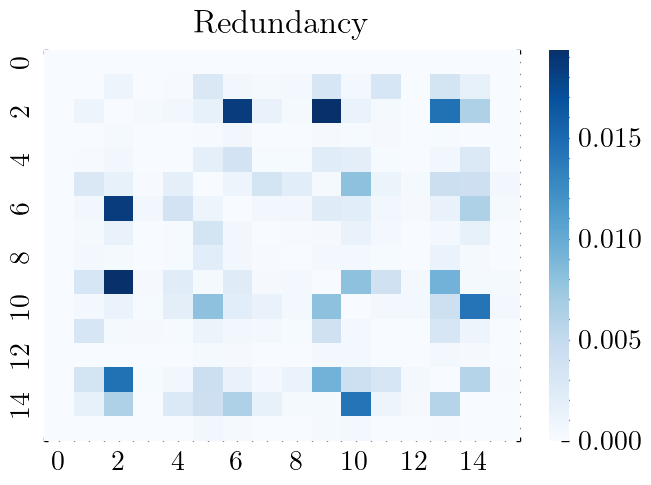

In [14]:
# visualize redundancy term using heatmap
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(redundancy, cmap='Blues', ax=ax)
ax.set_title('Redundancy')
# set dpi to 300
plt.tight_layout()
plt.savefig('./redundancy.png', dpi=300)
plt.show()

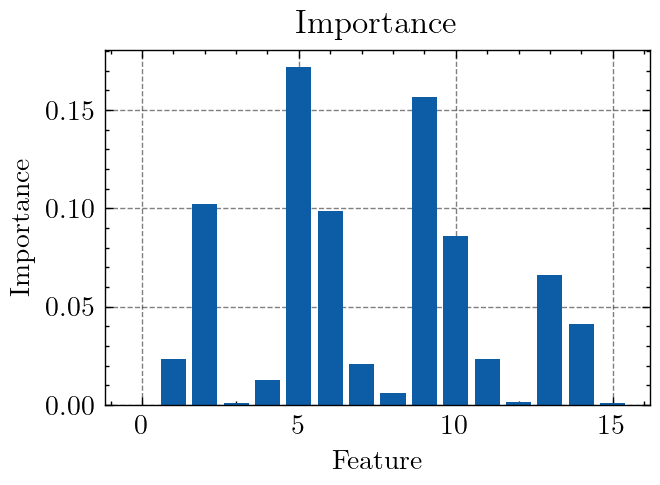

In [15]:
# visualize importance term using bar plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(PIC_SIZE), importance)
ax.set_title('Importance')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
# set dpi to 300
plt.tight_layout()
plt.savefig('./importance.png', dpi=300)
